In [288]:
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.constants as const

from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d


## Establish baseline costs
Largely dervied from [this paper](https://www.researchgate.net/publication/341420273_Cost_Analysis_of_Direct_Air_Capture_and_Sequestration_Coupled_to_Low-Carbon_Thermal_Energy_in_the_US)

In [289]:
costs = {
    "capex": {
        "2018": {
            "contactor": 111.48,
            "fan": 6.48,
            "vacuum_pump": 5.08,
            "heat_exchanger": 1.97
        }
    },
    "opex": {
        "2018": {
            "fan": 16.26,
            "vacuum_pump": 12.19,
            "compression": 6.63,
            "maintenance": 23.96,
            "labor": 7.27,
            "steam": 22.68
        }
    }
}

compression_capex = 6.00 # McQueen et al 2020 supplement pg 21
trucking_capex = 9.01 - compression_capex

costs["capex"]["2018"]["compression"] = compression_capex
costs["capex"]["2018"]["trucking"] = trucking_capex

base_capex_2018 = sum(costs["capex"]["2018"].values())
base_opex_2018 = sum(costs["opex"]["2018"].values())

print(f"Verified: ${base_capex_2018:.2f} capex, ${base_opex_2018:.2f} opex (to gate) matches McQueen et al 2020")

# McQueen et al 2020 doesn't include storage costs 
# midpoint of DOE, 2014 estimate ($7-13) used (see ch.7 http://nap.nationalacademies.org/25259)
costs["opex"]["2018"]["storage"] = 10.00

base_opex_2018_to_grave = sum(costs["opex"]["2018"].values())
print(f"To grave opex is ${base_opex_2018_to_grave:.2f}")

Verified: $134.02 capex, $88.99 opex (to gate) matches McQueen et al 2020
To grave opex is $98.99


#### Forecast baseline to 2030

In [290]:
def forecast_improvement(initial_value, rate, reference_year, direction="decrease", target_year=2030):
    if direction == "decrease":
        end_value = initial_value * (1 - rate) ** (target_year - reference_year)
    else:
        end_value = initial_value * (1 + rate) ** (target_year - reference_year)
    return end_value

# Unless otherwise specified, all improvement rates are from supplement to
# https://pubs.rsc.org/en/content/articlelanding/2019/ee/c9ee01526d 
adsorption_ir_lower = 0.033097
adsorption_ir_mean = 0.1172984
adsorption_ir = (adsorption_ir_lower + adsorption_ir_mean) / 2

contactor_capex_2030 = forecast_improvement(costs["capex"]["2018"]["contactor"], adsorption_ir, 2018)

costs["capex"]["2030"] = {
    "contactor": contactor_capex_2030,
    "fan": costs["capex"]["2018"]["fan"],
    "vacuum_pump": costs["capex"]["2018"]["vacuum_pump"],
    "heat_exchanger": costs["capex"]["2018"]["heat_exchanger"],
    "compression": costs["capex"]["2018"]["compression"],
    "trucking": costs["capex"]["2018"]["trucking"]
}

print(f"Contactor capex forecast to decrease to ${contactor_capex_2030:.2f} in 2030, given improvement "
      f"rate of {adsorption_ir:.2%}.")
print(f"No improvement assumed for other capex categories; baseline 2030 capex estimated at "
      f"${sum(costs['capex']['2030'].values()):.2f}.")

Contactor capex forecast to decrease to $43.63 in 2030, given improvement rate of 7.52%.
No improvement assumed for other capex categories; baseline 2030 capex estimated at $66.17.


In [291]:
nas_thermal_requirement_low = 3.4 # GJ/ton ch. 5 http://nap.nationalacademies.org/25259
an_et_al_thermal_requirement_high = 2.03 # https://www.osti.gov/pages/servlets/purl/2203824
thermal_requirement_2030 = (nas_thermal_requirement_low + an_et_al_thermal_requirement_high) / 2
steam_price = 2.9
base_steam_opex_2030 = thermal_requirement_2030 * steam_price
print(f"2030 baseline steam opex forecast to be ${base_steam_opex_2030:.2f}, given thermal "
      f"requirement of {thermal_requirement_2030:.2f} GJ/ton.")

capex_2018 = sum(costs["capex"]["2018"].values())

mtc_fraction = costs["opex"]["2018"]["maintenance"] / capex_2018
base_mtc_opex_2030 = mtc_fraction * sum(costs["capex"]["2030"].values())

labor_fraction = costs["opex"]["2018"]["labor"] / capex_2018
base_labor_opex_2030 = labor_fraction * sum(costs["capex"]["2030"].values())
print(f"2030 baseline maintenance opex forecast to be ${base_mtc_opex_2030:.2f}, labor opex forecast "
      f"to be ${base_labor_opex_2030:.2f} (uses 2018 "
      f"fractions).")

storage_ir = 0.013336
base_storage_opex_2030 = forecast_improvement(costs["opex"]["2018"]["storage"], storage_ir, 2013)
print(f"2030 baseline storage opex forecast to be ${base_storage_opex_2030:.2f}, given improvement rate "
      f"of {storage_ir:.2%}.")

costs["opex"]["2030"] = {
    "fan": costs["opex"]["2018"]["fan"],
    "vacuum_pump": costs["opex"]["2018"]["vacuum_pump"],
    "compression": costs["opex"]["2018"]["compression"],
    "maintenance": base_mtc_opex_2030,
    "labor": base_labor_opex_2030,
    "steam": base_steam_opex_2030,
    "storage": base_storage_opex_2030
}

print(f"2030 baseline opex forecast to be ${sum(costs['opex']['2030'].values()):.2f}.")


2030 baseline steam opex forecast to be $7.87, given thermal requirement of 2.71 GJ/ton.
2030 baseline maintenance opex forecast to be $11.83, labor opex forecast to be $3.59 (uses 2018 fractions).
2030 baseline storage opex forecast to be $7.96, given improvement rate of 1.33%.
2030 baseline opex forecast to be $66.33.


In [292]:
total_base_cost_2018 = sum(costs["capex"]["2018"].values()) + sum(costs["opex"]["2018"].values())
total_base_cost_2030 = sum(costs["capex"]["2030"].values()) + sum(costs["opex"]["2030"].values())
print(f"Baseline 2018 total gross cost: ${total_base_cost_2018:.2f}, 2030 total gross cost: "
      f"${total_base_cost_2030:.2f}")

Baseline 2018 total gross cost: $233.01, 2030 total gross cost: $132.50


## Estimate baseline cost net of CO2 emissions from capture process

In [293]:
# US average electricity emissions from https://www.epa.gov/climateleadership/ghg-emission-factors-hub 
grid_intensities = {
    2014: 1232.35,
    2015: 1136.53,
    2018: 998.4,
    2020: 947.2,
    2021: 884.2,
    2022: 818.3,
    2023: 852.3,
    2024: 823.1
}

grid_intensities_df = pd.DataFrame(list(grid_intensities.items()), columns=["year", "grid_intensity_lb_per_MWh"])
grid_intensities_df["grid_intensity_g_per_kWh"] = (
        grid_intensities_df["grid_intensity_lb_per_MWh"] * 453.592 / 1000
)
grid_intensities_df


,year,grid_intensity_lb_per_MWh,grid_intensity_g_per_kWh
0,2014,1232.35,558.984101
1,2015,1136.53,515.520916
2,2018,998.40,452.866253
3,2020,947.20,429.642342
4,2021,884.20,401.066046
5,2022,818.30,371.174334
6,2023,852.30,386.596462
7,2024,823.10,373.351575


#### Forecast 2030 grid intensities
Opted for linear regression over power law

Discarded: 2030 grid intensity forecasted to be 283.25 g/kWh using power law across 8 interrupted observations.


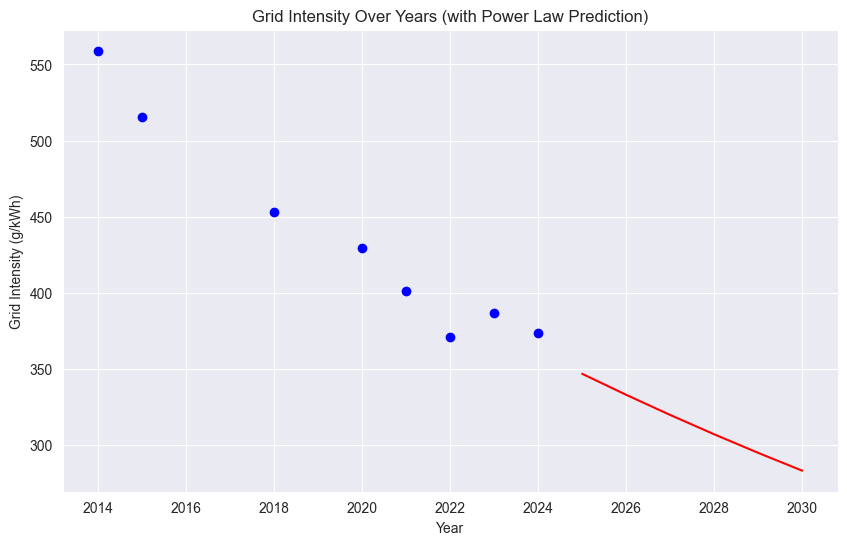

In [294]:
factors_X_log = np.log(grid_intensities_df['year'])
factors_y_log = np.log(grid_intensities_df['grid_intensity_g_per_kWh'])

model = LinearRegression()
model.fit(factors_X_log.values.reshape(-1, 1), factors_y_log.values)

future_years = np.array([2025, 2026, 2027, 2028, 2029, 2030])
log_predictions = model.predict(np.log(future_years).reshape(-1, 1))

transformed_predictions = np.exp(log_predictions)
unused_2030_grid_intensity = transformed_predictions[-1]
print(f"Discarded: 2030 grid intensity forecasted to be {unused_2030_grid_intensity:.2f} g/kWh using "
      f"power law across 8 interrupted observations.")

plt.figure(figsize=(10, 6))
plt.scatter(grid_intensities_df['year'], grid_intensities_df['grid_intensity_g_per_kWh'], color='blue')
plt.plot(future_years, transformed_predictions, color='red')
plt.title('Grid Intensity Over Years (with Power Law Prediction)')
plt.xlabel('Year')
plt.ylabel('Grid Intensity (g/kWh)')
plt.grid(True)
plt.show()

2030 grid intensity forecasted to be 290.73 g/kWh using linear regression on 5 most recent, uninterrupted observations.


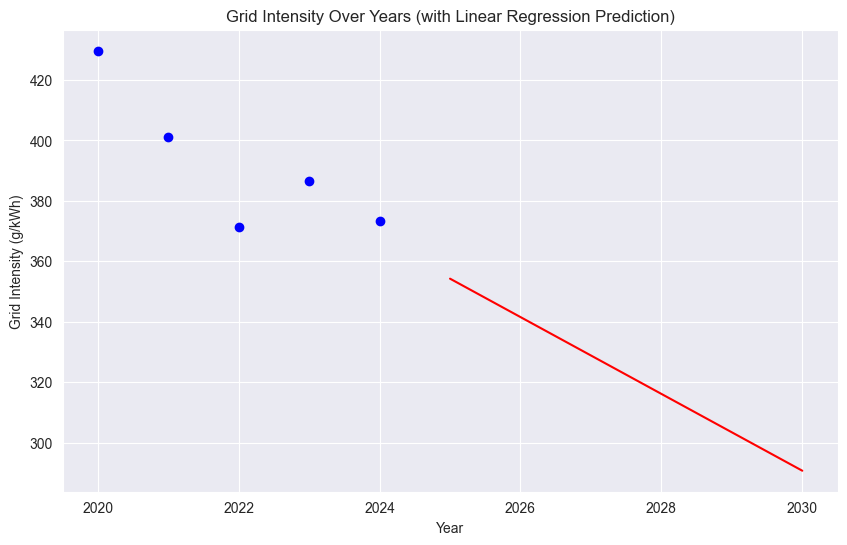

In [295]:
recent_grid_intensities_df = grid_intensities_df[grid_intensities_df['year'] >= 2020]

factors_X = recent_grid_intensities_df['year'].values.reshape(-1, 1)
factors_y = recent_grid_intensities_df['grid_intensity_g_per_kWh'].values

model = LinearRegression()
model.fit(factors_X, factors_y)

# Predict the value for 2030
pred_2030_grid_intensity = model.predict(np.array([[2030]]))[0]
print(f"2030 grid intensity forecasted to be {pred_2030_grid_intensity:.2f} g/kWh using linear regression "
      f"on 5 most recent, uninterrupted observations.")

plt.figure(figsize=(10, 6))
plt.scatter(recent_grid_intensities_df['year'],
            recent_grid_intensities_df['grid_intensity_g_per_kWh'],
            color='blue')
plt.plot(future_years, model.predict(future_years.reshape(-1, 1)), color='red')
plt.title('Grid Intensity Over Years (with Linear Regression Prediction)')
plt.xlabel('Year')
plt.ylabel('Grid Intensity (g/kWh)')
plt.grid(True)
plt.show()

#### Apply forecasted 2030 emissions factors

In [296]:
electrical_requirement = 1.5 # GJ/ton
gj_to_kwh = 277.778
electrical_requirement_kwh = electrical_requirement * gj_to_kwh
paper_grid_intensity = 490 # g/kWh

paper_electric_co2_footprint = (paper_grid_intensity * electrical_requirement_kwh) / 1000000 # ton/ton
print(f"Paper's electric CO2 footprint: {paper_electric_co2_footprint:.2f} ton-CO2 emitted/ton-CO2 captured, "
      f"given grid intensity of {paper_grid_intensity:.2f} g/kWh.")
base_electric_co2_footprint_2030 = (pred_2030_grid_intensity * electrical_requirement_kwh) / 1000000 # ton/ton
print(f"Baseline 2030 e-CO2 footprint forecasted to be {base_electric_co2_footprint_2030:.2f} t-CO2 " 
      f"emit/t-CO2 captured, given forecasted grid intensity of {pred_2030_grid_intensity:.2f} g/kWh.")


Paper's electric CO2 footprint: 0.20 ton-CO2 emitted/ton-CO2 captured, given grid intensity of 490.00 g/kWh.
Baseline 2030 e-CO2 footprint forecasted to be 0.12 t-CO2 emit/t-CO2 captured, given forecasted grid intensity of 290.73 g/kWh.


In [297]:
heat_intensity = 227 # g/kWh
heat_requirement_kwh = thermal_requirement_2030 * gj_to_kwh
paper_thermal_requirement = 6.0 # GJ/ton
paper_heat_requirement_kwh = paper_thermal_requirement * gj_to_kwh

paper_heat_co2_footprint = (heat_intensity * paper_heat_requirement_kwh) / 1000000 # ton/ton
print(f"Paper's heat CO2 footprint: {paper_heat_co2_footprint:.2f} ton-CO2 emitted/ton-CO2 captured, "
      f"given thermal requirement of {paper_thermal_requirement:.2f} GJ/ton")
base_heat_co2_footprint_2030 = (heat_intensity * heat_requirement_kwh) / 1000000 # ton/ton
print(f"Baseline 2030 h-CO2 footprint forecasted to be {base_heat_co2_footprint_2030:.2f} ton-CO2 "
      f"emit/ton-CO2 captured, given forecasted thermal requirement of {thermal_requirement_2030:.2f} GJ/ton.")


Paper's heat CO2 footprint: 0.38 ton-CO2 emitted/ton-CO2 captured, given thermal requirement of 6.00 GJ/ton
Baseline 2030 h-CO2 footprint forecasted to be 0.17 ton-CO2 emit/ton-CO2 captured, given forecasted thermal requirement of 2.71 GJ/ton.


In [298]:
trucking_intensity = 0.168 # kg/ton-mile
trucking_unit_costs = 0.14 # $/ton-mile, from McQueen supplement pg. 21
trucking_units = trucking_capex / trucking_unit_costs

paper_trucking_footprint = trucking_intensity * trucking_units / 1000
print(f"Paper's trucking CO2 footprint: {paper_trucking_footprint:.3f} ton-CO2 emitted/ton-CO2 captured, "
      f"given {trucking_units:.2f} ton-miles of trucking and intensity of {trucking_intensity:.3f} kg/ton-mile.")

# Balance of DAC emissions footprint assumed to be from embodied materials
paper_base_co2_footprint = .65
paper_embodied_material_emissions = (paper_base_co2_footprint - paper_electric_co2_footprint - 
                                     paper_heat_co2_footprint - paper_trucking_footprint)
print(f"Implies embodied material emissions of {paper_embodied_material_emissions:.3f} ton-CO2 emitted/ton-CO2 "
      f"captured (paper's total CO2 footprint is {paper_base_co2_footprint:.2f} t-CO2 emit/t-CO2 captured "
      f"less electric, heat, and trucking footprints).")


Paper's trucking CO2 footprint: 0.004 ton-CO2 emitted/ton-CO2 captured, given 21.50 ton-miles of trucking and intensity of 0.168 kg/ton-mile.
Implies embodied material emissions of 0.064 ton-CO2 emitted/ton-CO2 captured (paper's total CO2 footprint is 0.65 t-CO2 emit/t-CO2 captured less electric, heat, and trucking footprints).


In [299]:
base_co2_footprint_2030 = (base_electric_co2_footprint_2030 + base_heat_co2_footprint_2030 + 
                           paper_trucking_footprint + paper_embodied_material_emissions)

base_net_cost_2030 = total_base_cost_2030 / (1 - base_co2_footprint_2030)
base_net_cost_2018 = total_base_cost_2018 / (1 - paper_base_co2_footprint)
print(f"Baseline 2030 net cost forecasted to be ${base_net_cost_2030:.2f} given forecast "
      f"CO2 footprint of {base_co2_footprint_2030:.2f} t-CO2 emitted/ton-CO2 captured (2018 net cost: "
        f"${base_net_cost_2018:.2f}, {paper_base_co2_footprint:.2f} footprint).")

costs["net"] = {
    "2018": base_net_cost_2018,
    "2030": base_net_cost_2030
}

costs


Baseline 2030 net cost forecasted to be $206.98 given forecast CO2 footprint of 0.36 t-CO2 emitted/ton-CO2 captured (2018 net cost: $665.74, 0.65 footprint).


{'capex': {'2018': {'contactor': 111.48,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01},
  '2030': {'contactor': 43.62985545245635,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01}},
 'opex': {'2018': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 23.96,
   'labor': 7.27,
   'steam': 22.68,
   'storage': 10.0},
  '2030': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 11.829799557087407,
   'labor': 3.589425825543633,
   'steam': 7.873499999999999,
   'storage': 7.959353686047504}},
 'net': {'2018': 665.7428571428571, '2030': 206.9796574624361}}

## Model Aerology costs

In [300]:
# Starting point for Aerology costs is the baseline 2030 costs
costs["opex"]["aero"] = {
    "fan": costs["opex"]["2030"]["fan"],
    "vacuum_pump": costs["opex"]["2030"]["vacuum_pump"],
    "compression": costs["opex"]["2030"]["compression"],
    "maintenance": costs["opex"]["2030"]["maintenance"],
    "labor": costs["opex"]["2030"]["labor"],
    "steam": costs["opex"]["2030"]["steam"],
    "storage": costs["opex"]["2030"]["storage"]
}
costs["capex"]["aero"] = {
    "contactor": costs["capex"]["2030"]["contactor"],
    "fan": costs["capex"]["2030"]["fan"],
    "vacuum_pump": costs["capex"]["2030"]["vacuum_pump"],
    "heat_exchanger": costs["capex"]["2030"]["heat_exchanger"],
    "compression": costs["capex"]["2030"]["compression"],
    "trucking": costs["capex"]["2030"]["trucking"]
}

# sorbent propelled through air, rather than using fan to push air through sorbent
del costs["capex"]["aero"]["fan"]
del costs["opex"]["aero"]["fan"]

# already operating in mild vacuum
del costs["capex"]["aero"]["vacuum_pump"]
del costs["opex"]["aero"]["vacuum_pump"]

# energy cost shifted to capex/plant mod (i.e. solar power) 
del costs["opex"]["aero"]["steam"]
del costs["opex"]["aero"]["compression"]

# sea transport/subsea storage modeled separately
del costs["opex"]["aero"]["storage"]
del costs["capex"]["aero"]["trucking"]

# will recalculate maintenance and labor with increased capex
del costs["opex"]["aero"]["maintenance"]
del costs["opex"]["aero"]["labor"]

stripped_aero_capex = sum(costs["capex"]["aero"].values())
stripped_aero_opex = sum(costs["opex"]["aero"].values())
stripped_aero_tot_gross_cost = stripped_aero_capex + stripped_aero_opex
print(f"Stripped Aerology 2030 total gross cost: ${stripped_aero_tot_gross_cost:.2f} (capex: "
      f"${stripped_aero_capex:.2f}, opex: ${stripped_aero_opex:.2f}) before adding \"plant mod\""
      f" and sea transport/subsea storage costs.")


Stripped Aerology 2030 total gross cost: $51.60 (capex: $51.60, opex: $0.00) before adding "plant mod" and sea transport/subsea storage costs.


#### Model energy efficiencies for Aerology loitering flight vehicle (LFV)
LFV distinguished from presumed drone-like solution to transport captured CO2 from airship to sea surface

In [301]:
q_learned_dni_at_5400m = 484.073401 # W/m²
q_learned_dni_at_sea_level = 403.240724
# average surface irradiance for Americas is 197.66233023551354 W/m² (from NREL, not NASA Power)
daily_irradiance = 484.073401

unscaled_thermal_eff = { # pixels from https://www.sciencedirect.com/science/article/pii/S1876610214015604
    0: 0, # x-axis: y-axis
    18: 65,
    34: 117,
    50: 134,
    68: 143,
    85: 148,
    102: 152,
    119: 154,
    136: 156,
    152: 158,
    169: 159,
    186: 160,
    203: 161,
    253: 162    
}


Starting solar-thermal efficiency: 67.66%, given daily irradiance of 484.07 W/m².


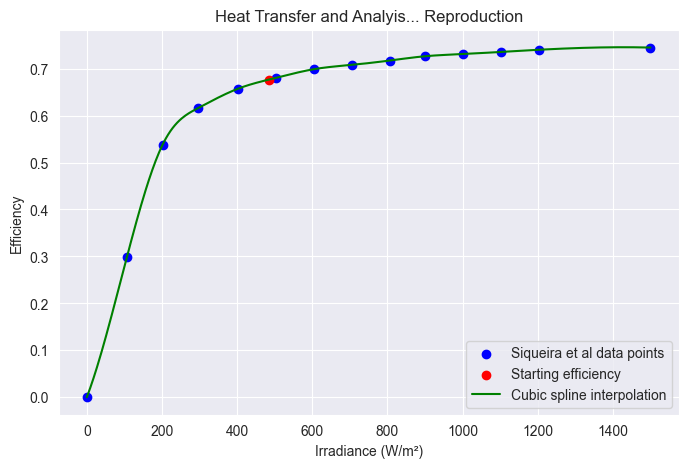

In [302]:
def scale_values(value, old_min, old_max, new_min, new_max):
    return (value - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

def estimate_efficiency(irradiance):
    return spline_interpolator(irradiance)

# Scale the data from measured pixels to axis values (0-1500 W/m2 for irradiance, 0-0.8 for efficiency) 
px_x_vals = np.array(list(unscaled_thermal_eff.keys()))
px_y_vals = np.array(list(unscaled_thermal_eff.values()))
x_vals_scaled = scale_values(px_x_vals, 0, 253, 0, 1500)
y_vals_scaled = scale_values(px_y_vals, 0, 174, 0.0, 0.8)

spline_interpolator = interp1d(x_vals_scaled, y_vals_scaled, kind='cubic', fill_value="extrapolate")

est_solar_thermal_efficiency_2024 = estimate_efficiency(daily_irradiance)
print(f"Starting solar-thermal efficiency: {est_solar_thermal_efficiency_2024:.2%}, given daily irradiance "
      f"of {daily_irradiance:.2f} W/m².")

x_line = np.linspace(min(x_vals_scaled), max(x_vals_scaled), 500)
y_line = spline_interpolator(x_line)

plt.figure(figsize=(8, 5))
plt.scatter(x_vals_scaled, y_vals_scaled, color='blue', label='Siqueira et al data points')
plt.scatter(daily_irradiance, est_solar_thermal_efficiency_2024, color='red', label='Starting efficiency')
plt.plot(x_line, y_line, color='green', label='Cubic spline interpolation')
plt.title('Heat Transfer and Analyis... Reproduction')
plt.xlabel('Irradiance (W/m²)')
plt.ylabel('Efficiency')
plt.legend()
plt.grid(True)
plt.show()


2030 solar-thermal efficiency forecasted to be 75.13%.


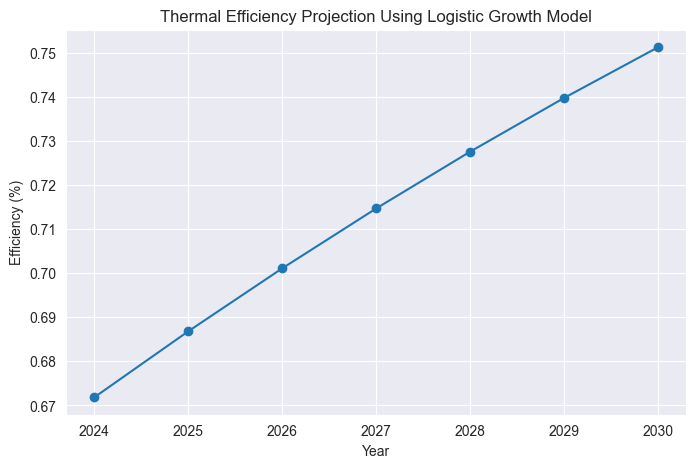

In [303]:
# Applying linear improvement rate to thermal efficiency results in efficiency > 100%
# Used logistic growth instead and assumed growth rate equal to improvement rate
def logistic_growth(t, max_limit, k, t_0):
    return max_limit / (1 + np.exp(-k * (t - t_0)))

upper_bound = .90  # https://www.osti.gov/biblio/1090218
solar_ir = 0.09  # https://www.sciencedirect.com/science/article/abs/pii/S0960148114001451
calibrated_t0 = 2012 # calibrated to intersect ~68% at 2024 (i.e. starting efficiency modeled above)
start_year = 2024
end_year = 2030

years = np.arange(start_year, end_year + 1)
efficiencies = [logistic_growth(t, upper_bound, solar_ir, calibrated_t0) for t in years]

csp_thermal_eff_2030 = efficiencies[-1]
print(f"2030 solar-thermal efficiency forecasted to be {csp_thermal_eff_2030:.2%}.")

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(years, efficiencies, marker='o')
plt.title('Thermal Efficiency Projection Using Logistic Growth Model')
plt.xlabel('Year')
plt.ylabel('Efficiency (%)')
plt.grid(True)
plt.show()

PV (i.e. solar-electric) efficiency forecasted to be 20.49%, given daily irradiance of 484.07 W/m².


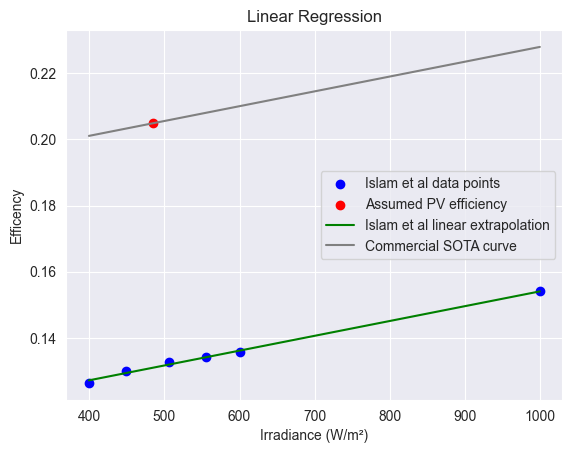

In [304]:
unscaled_pv_eff = { # pixels from https://ieeexplore.ieee.org/abstract/document/6861716
    221: 245,
    248: 252,
    280: 257,
    307: 260,
    332: 263
}

pv_px_x_vals = np.array(list(unscaled_pv_eff.keys()))
pv_px_y_vals = np.array(list(unscaled_pv_eff.values()))

# Scale the data from measured pixels to axis values (0-600 W/m2 for irradiance, 0-0.18 for efficiency)
pv_x_vals = scale_values(pv_px_x_vals, 0, 332, 0, 600)
pv_y_vals = scale_values(pv_px_y_vals, 0, 349, 0.0, 0.18)

pv_x_vals_reshaped = np.array(pv_x_vals).reshape(-1, 1)
model = LinearRegression()
model.fit(pv_x_vals_reshaped, pv_y_vals)
y_pred = model.predict(pv_x_vals_reshaped)

stc_irradiance = 1000 # standard test conditions, 1000 W/m²
islam_et_al_pv_stc_eff = model.predict(np.array([[stc_irradiance]]))[0]
pv_x_vals = np.append(pv_x_vals, stc_irradiance)
pv_y_vals = np.append(pv_y_vals, islam_et_al_pv_stc_eff)
y_ext_pred = model.predict(np.array(pv_x_vals).reshape(-1, 1))

# https://maxeon.com/us/sites/default/files/2024-03/sp_max6_66c_res_440_435_425_dc_ds_en_ltr_552142.pdf
commercial_sota_stc_eff = .228 

pv_improvement_shift = commercial_sota_stc_eff - islam_et_al_pv_stc_eff 
commercial_sota_curve = y_ext_pred + pv_improvement_shift

est_pv_efficiency = model.predict(np.array([[daily_irradiance]]))[0] + pv_improvement_shift
print(f"PV (i.e. solar-electric) efficiency forecasted to be {est_pv_efficiency:.2%}, given daily irradiance "
      f"of {daily_irradiance:.2f} W/m².")

plt.scatter(pv_x_vals, pv_y_vals, color='blue', label='Islam et al data points')
plt.scatter(daily_irradiance, est_pv_efficiency, color='red', label='Assumed PV efficiency')
plt.plot(pv_x_vals, y_ext_pred, color='green', label='Islam et al linear extrapolation')
plt.plot(pv_x_vals, commercial_sota_curve, color='grey', label='Commercial SOTA curve')
plt.xlabel('Irradiance (W/m²)')
plt.ylabel('Efficency')
plt.title('Linear Regression')
plt.legend()
plt.show()

2030 PV efficiency forecasted to be 24.72%.


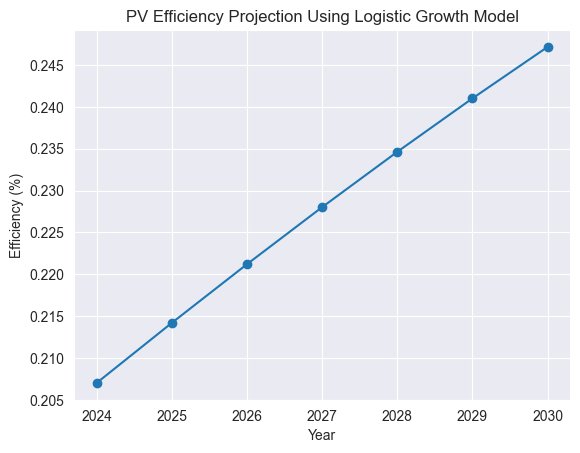

In [305]:
# Using logistic growth model for PV efficiency again so as to not overestimate terminal efficiency
pv_upper_bound = .339 # Perovskite/Si tandem cell https://www.nrel.gov/pv/cell-efficiency.html
pv_calibrated_t0 = 2019 # calibrated to intersect ~21% at 2024 (i.e. starting efficiency modeled above)
pv_start_year = 2024
pv_end_year = 2030

pv_years = np.arange(pv_start_year, pv_end_year + 1)
pv_efficiencies = [logistic_growth(t, pv_upper_bound, solar_ir, pv_calibrated_t0) for t in pv_years]

pv_eff_2030 = pv_efficiencies[-1]
print(f"2030 PV efficiency forecasted to be {pv_eff_2030:.2%}.")

plt.plot(pv_years, pv_efficiencies, marker='o')
plt.title('PV Efficiency Projection Using Logistic Growth Model')
plt.xlabel('Year')
plt.ylabel('Efficiency (%)')
plt.grid(True)
plt.show()


#### Estimate Aerology energy and associated weight per m² of CSP panels

In [306]:
csp_wh_per_m2 = daily_irradiance * csp_thermal_eff_2030 * 24
annual_operating_days = 330
csp_ann_gj_per_m2 = csp_wh_per_m2 * 3.6e-6 * annual_operating_days
csp_ann_t_co2_per_m2 = csp_ann_gj_per_m2 / thermal_requirement_2030
print(f"Each m² of CSP estimated to generate {csp_ann_gj_per_m2:.2f} GJ/yr thermal engergy "
      f"({csp_wh_per_m2:.0f} Wh/m²/day): provides thermal requirement for {csp_ann_t_co2_per_m2:.2f} "
      f"tons of CO2 capture annually.")


Each m² of CSP estimated to generate 10.37 GJ/yr thermal engergy (8729 Wh/m²/day): provides thermal requirement for 3.82 tons of CO2 capture annually.


In [307]:
csp_frame_kg_per_m2 = 15.0 # https://www.osti.gov/biblio/1888029
csp_mirror_kg_per_m2 = 7.5
csp_weight_kg_per_m2 = csp_frame_kg_per_m2 + csp_mirror_kg_per_m2
print(f"Each m² of CSP carries {csp_weight_kg_per_m2:.2f}kg of mirror and frame associated with CSP itself.")

Each m² of CSP carries 22.50kg of mirror and frame associated with CSP itself.


In [308]:
sorbent_efficiency = 7.5 # kg sorbent/ton-CO2 https://iopscience.iop.org/article/10.1088/2516-1083/abf1ce/pdf
sorbent_efficiency_2030 = forecast_improvement(sorbent_efficiency, adsorption_ir, 2021)
print(f"Sorbent efficiency forecasted to be {sorbent_efficiency_2030:.2f} kg sorbent/ton-CO2 in 2030.")

monolith_ratio = 0.2
kg_monolith_per_ton_co2 = sorbent_efficiency_2030 * monolith_ratio
kg_contactor_per_ton_co2 = sorbent_efficiency_2030 + kg_monolith_per_ton_co2

contactor_kg_per_m2_csp = kg_contactor_per_ton_co2 * csp_ann_t_co2_per_m2
print(f"Incl. sorbent support structures, {kg_contactor_per_ton_co2:.2f}kg carried for contactor "
      f"per ton-CO2: each m² of CSP estimated to require {contactor_kg_per_m2_csp:.2f}kg of contactor "
      f"material annually.")


Sorbent efficiency forecasted to be 3.71 kg sorbent/ton-CO2 in 2030.
Incl. sorbent support structures, 4.45kg carried for contactor per ton-CO2: each m² of CSP estimated to require 17.01kg of contactor material annually.


In [309]:
# Assumes compression entirely accomplished on sea platform
# TODO - investigate partial compression on airship to reduce air-sea surface CO2 transport volumes
g_co2_capture_per_min_per_m2_csp = csp_ann_t_co2_per_m2 * 1000 * 1000 / (365 * 24 * 60)
molar_mass_co2 = 44.01  
molar_volume_at_stp = 22.4

cycle_time = 16 # minutes, see ch. 5 http://nap.nationalacademies.org/25259

moles_co2_per_minute_per_m2 = g_co2_capture_per_min_per_m2_csp / molar_mass_co2
stp_liter_co2_per_cycle_per_m2 = moles_co2_per_minute_per_m2 * molar_volume_at_stp * cycle_time

sea_level_temp = 288.15  # K
slp = 101325  # Pa
g = const.g
lapse_rate = 0.0065  # K/m
R = 287.058  # Specific gas constant for dry air in J/(kg*K)

temp_at_5400m = sea_level_temp - lapse_rate * 5400
press_at_5400m = slp * (temp_at_5400m / sea_level_temp) ** (g / (lapse_rate * R))

liter_co2_per_cycle_per_m2_5400m = ((stp_liter_co2_per_cycle_per_m2 * (slp / 1000) / (press_at_5400m / 1000)) *
                                (temp_at_5400m / 273.15))
print(f"Each m² of CSP estimated to produce {liter_co2_per_cycle_per_m2_5400m:.2f} liters of "
      f"uncompressed CO2 per {cycle_time}m-cycle at 5400m.")


Each m² of CSP estimated to produce 108.50 liters of uncompressed CO2 per 16m-cycle at 5400m.


In [310]:
hdpe_density = 0.95  # g/cm^3, recycled high-density polyethylene
wall_thickness_cm = 0.5  # cm
ratio_diameter_height = 3.5 / 27.5  # A220 fuselage dimensions

cycle_co2_per_m2_csp = liter_co2_per_cycle_per_m2_5400m * 1000  # cubic cm

# Calculate the inner height (H) of the cylinder using the cubic root
# Rearranged formula: H = [(4 * V) / (π * ratio^2)]^(1/3)
inner_height_cm = ((4 * cycle_co2_per_m2_csp) / (math.pi * (ratio_diameter_height ** 2))) ** (1/3)
inner_diameter_cm = inner_height_cm * ratio_diameter_height

# Calculate the outer dimensions
outer_diameter_cm = inner_diameter_cm + 2 * wall_thickness_cm
outer_height_cm = inner_height_cm + 2 * wall_thickness_cm

# Volume of HDPE = Volume of outer cylinder - Volume of inner cylinder
vol_hdpe_per_m2 = (math.pi * (outer_diameter_cm/2)**2 * outer_height_cm) - cycle_co2_per_m2_csp # cm^3

# Calculate the mass of HDPE needed
hdpe_kg_per_m2_csp = (hdpe_density * vol_hdpe_per_m2) / 1000  # converting grams to kilograms
print(f"To contain CO2 produced by each m² of CSP, {hdpe_kg_per_m2_csp:.2f}kg of HDPE is required.")

To contain CO2 produced by each m² of CSP, 8.62kg of HDPE is required.


#### Estimate LFV dimensions
Assumes envelope size of Loon's Quail balloon (i.e. v1.6) and lifting capability of Raptor (i.e. Hammerhead 
Gen 1). Loon specifications available at [Loon Library](https://storage.googleapis.com/x-prod.appspot.com/files/The%20Loon%20Library.pdf).

In [311]:
# https://vimeo.com/389506892?utm_campaign=2470763&utm_source=affiliate&utm_channel=affiliate&cjevent=c37b9631eb7411ee82ea00660a82b839&clickid=c37b9631eb7411ee82ea00660a82b839
battery_density_2019 = 250 # Wh/kg
quail_storage_capacity = 4146 # Wh
quail_battery_weight = quail_storage_capacity / battery_density_2019

# https://maxeon.com/us/sites/default/files/2024-03/sp_max6_66c_res_440_435_425_dc_ds_en_ltr_552142.pdf
pv_panel_h = 1.872 # m
pv_panel_w = 1.032 
pv_panel_area = pv_panel_h * pv_panel_w
pv_panel_weight = 20.9 # kg
pv_panel_kg_per_m2 = pv_panel_weight / pv_panel_area

quail_panel_area = 4.6
quail_panel_weight = quail_panel_area * pv_panel_kg_per_m2
quail_electric_weight = quail_battery_weight + quail_panel_weight
print(f"Quail estimated to carry {quail_electric_weight:.2f}kg assoc. with power (battery and solar panels).")

quail_max_lifting_weight = 261.2
quail_balloon_and_flight_sys_weight = quail_max_lifting_weight - quail_electric_weight
print(f"Quail balloon and flight systems estimated to weigh {quail_balloon_and_flight_sys_weight:.2f}kg "
      f"(includes and henceforth ignores weight of Loon communication payload).")


Quail estimated to carry 66.35kg assoc. with power (battery and solar panels).
Quail balloon and flight systems estimated to weigh 194.85kg (includes and henceforth ignores weight of Loon communication payload).


In [312]:
raptor_daily_harvest = 129000  # Wh
raptor_speed = 5.25  # m/s
raptor_propulsion_power = raptor_daily_harvest * .3 / 24 

target_speed = 3.0
# Propulsion power required proportional to velocity cubed
propulsion_power_req = raptor_propulsion_power * (target_speed / raptor_speed) ** 3 # W
propulsion_energy_req = propulsion_power_req * 24 # Wh

# Assume flight systems electric requirement equal to half of Plover daily harvest
flight_sys_energy_req = 9267 / 2  # Wh
total_electric_energy_req = propulsion_energy_req + flight_sys_energy_req

daily_solar_electric_harvest_per_m2_pv = daily_irradiance * pv_eff_2030 * 24 # Wh
pv_panel_area = total_electric_energy_req / daily_solar_electric_harvest_per_m2_pv
print(f"Each m² PV generates {daily_solar_electric_harvest_per_m2_pv / 1000:.2f} kWh/day: requires "
      f"{pv_panel_area:.2f}m² to meet electric demand of {total_electric_energy_req / 1000:.2f} kWh "
      f"({propulsion_energy_req / 1000:.2f} kWh propulsion, {flight_sys_energy_req / 1000:.2f} kWh flight "
      f"systems).")

pv_panel_weight = pv_panel_kg_per_m2 * pv_panel_area

quail_daily_harvest = 9730 # Wh
# Using Quail ignores v3 relationship but assumes offset by carrying comms payload demand
quail_storage_pct_of_harvest = quail_storage_capacity / quail_daily_harvest
battery_storage_capacity = quail_storage_pct_of_harvest * total_electric_energy_req
battery_density = 500 # Wh/kg https://amprius.com/the-all-new-amprius-500-wh-kg-battery-platform-is-here/
battery_weight = battery_storage_capacity / battery_density

electric_weight = battery_weight + pv_panel_weight
print(f"Electric weight estimated to be {electric_weight:.2f}kg ({battery_weight:.2f}kg battery, "
      f"{pv_panel_weight:.2f}kg PV panel).")


Each m² PV generates 2.87 kWh/day: requires 4.13m² to meet electric demand of 11.85 kWh (7.22 kWh propulsion, 4.63 kWh flight systems).
Electric weight estimated to be 54.76kg (10.10kg battery, 44.66kg PV panel).


In [313]:
M_air = 28.97e-3  # Molar mass of air (kg/mol)
M_hydrogen = 2.016e-3  # Molar mass of hydrogen (kg/mol)

density_air = (press_at_5400m * M_air) / (const.R * temp_at_5400m)
density_hydrogen = (press_at_5400m * M_hydrogen) / (const.R * temp_at_5400m)
density_diff = density_air - density_hydrogen

quail_envelope_vol = 2713
mass_lifted = quail_envelope_vol * density_diff
print(f"Envelope with volume {quail_envelope_vol}m³ (equal to Quail) estimated to lift "
      f"{mass_lifted:.2f}kg of payload to 5400m.")

Envelope with volume 2713m³ (equal to Quail) estimated to lift 1779.34kg of payload to 5400m.


In [314]:
kg_per_m2_csp = csp_weight_kg_per_m2 + contactor_kg_per_m2_csp + hdpe_kg_per_m2_csp

available_lifted_mass = mass_lifted - quail_balloon_and_flight_sys_weight
non_electric_payload = available_lifted_mass - electric_weight
print(f"{available_lifted_mass:.1f} kg of lifted mass available after balloon and flight systems; "
      f"{non_electric_payload:.1f} kg available after PV and battery.")

m2_csp = non_electric_payload / kg_per_m2_csp
annual_fv_co2_capture = m2_csp * csp_ann_t_co2_per_m2
print(f"{non_electric_payload:.1f} kg payload permits {m2_csp:.2f}m² of CSP, capturing "
      f"{annual_fv_co2_capture:.2f} tons of CO2 annually.")


1584.5 kg of lifted mass available after balloon and flight systems; 1529.7 kg available after PV and battery.
1529.7 kg payload permits 31.78m² of CSP, capturing 121.38 tons of CO2 annually.


#### Estimate LFV costs

In [315]:
q_cells_m2 = 1722 * 1134 / 1000000 # https://ressupply.com/q-cells?sort=p.price&order=DESC
q_cells_price = 315.0
nrel_2023_mpp = 2.68 # https://www.nrel.gov/docs/fy23osti/87303.pdf
nrel_2022_mpp = 3.18
nrel_2021_mpp = nrel_2022_mpp / 1.02
pv_panel_price_2021 = nrel_2021_mpp / nrel_2023_mpp * q_cells_price
quail_pv_cost = quail_panel_area * pv_panel_price_2021

# https://about.bnef.com/blog/battery-pack-prices-fall-to-an-average-of-132-kwh-but-rising-commodity-prices-start-to-bite
battery_price_2021 = 132 # $/kWh 
quail_battery_cost = quail_storage_capacity / 1000 * battery_price_2021
quail_power_cost = quail_pv_cost + quail_battery_cost
print(f"Quail power cost at shutdown in 2021 estimated at ${quail_power_cost:.2f} (${quail_pv_cost:.2f} "
      f"PV panels, ${quail_battery_cost:.2f} battery).")

# https://www.pcworld.com/article/428013/two-years-on-googles-project-loon-drifts-into-focus.html
quail_target_cost = 10000
# https://www.datacenterdynamics.com/en/analysis/connecting-world-balloon/
quail_quoted_cost = 40000
assumed_quail_vehicle_cost = (quail_target_cost + quail_quoted_cost) / 2
 
balloon_and_flight_systems_cost = assumed_quail_vehicle_cost - quail_power_cost
print(f"Quail flight vehicle total cost assumed to be ${assumed_quail_vehicle_cost:.2f}: less power, "
      f"will use ${balloon_and_flight_systems_cost:.2f} as cost of balloon and flight systems henceforth "
      f"(ignores cost of Loon comms payload).")

Quail power cost at shutdown in 2021 estimated at $2232.90 ($1685.62 PV panels, $547.27 battery).
Quail flight vehicle total cost assumed to be $25000.00: less power, will use $22767.10 as cost of balloon and flight systems henceforth (ignores cost of Loon comms payload).


In [316]:
csp_cost_per_m2 = 152.0 # https://www.nrel.gov/docs/fy21osti/77829.pdf
csp_cost_2030 = csp_cost_per_m2 * m2_csp
print(f"CSP cost in 2030: ${csp_cost_2030:.2f} ({m2_csp:.2f} m² of CSP panels, {csp_cost_per_m2:.2f} $/m²)")

pv_panel_price_2030 = forecast_improvement(q_cells_price, solar_ir, 2024)
pv_panel_price_per_m2_2030 = pv_panel_price_2030 / q_cells_m2
pv_cost_2030 = pv_panel_price_per_m2_2030 * pv_panel_area
print(f"PV panel cost in 2030: ${pv_cost_2030:.2f} ({pv_panel_area:.2f} m² of PV panels, "
      f"{pv_panel_price_per_m2_2030:.2f} $/m²)")

# https://about.bnef.com/blog/lithium-ion-battery-pack-prices-hit-record-low-of-139-kwh/
battery_price_2030 = 80.0 # $/kWh 
battery_cost_2030 = battery_storage_capacity / 1000 * battery_price_2030
print(f"Battery cost in 2030: ${battery_cost_2030:.2f} ({battery_storage_capacity / 1000:.2f} kWh battery, "
      f"{battery_price_2030:.2f} $/kWh)")

# https://www.spglobal.com/commodityinsights/en/our-methodology/price-assessments/chemicals/us-recycled-hdpe
rhdpe_price = .76 * 2.20462 # $/kg (converted from $/lb)
tank_weight_kg = hdpe_kg_per_m2_csp * m2_csp
lfv_co2_m3_per_cycle = liter_co2_per_cycle_per_m2_5400m * m2_csp / 1000
tank_cost = tank_weight_kg * rhdpe_price
print(f"Tank cost in 2030: ${tank_cost:.2f} ({tank_weight_kg:.2f} kg of HDPE to store "
      f"{lfv_co2_m3_per_cycle:.2f} m³ of CO2)")

payload_cost = csp_cost_2030 + pv_cost_2030 + battery_cost_2030 + tank_cost
lfv_cost = balloon_and_flight_systems_cost + payload_cost
print(f"Payload cost in 2030: ${payload_cost:.2f}; LFV cost estimated to be ${lfv_cost:.2f}")
balloon_lifetime = 5 # years
payload_lifetime = 20

fv_lifetime_values = np.array([balloon_lifetime, payload_lifetime])
fv_lifetime_weights = np.array([balloon_and_flight_systems_cost, payload_cost])

lfv_lifetime = np.average(fv_lifetime_values, weights=fv_lifetime_weights)
lfv_cost_per_ton_co2 = lfv_cost / annual_fv_co2_capture / lfv_lifetime
print(f"Loitering flight vehicle cost per ton-CO2 captured: ${lfv_cost_per_ton_co2:.2f} (blended LFV "
      f"lifetime: {lfv_lifetime:.2f} years).")
costs["capex"]["aero"]["loitering_flight_vehicle"] = lfv_cost_per_ton_co2


CSP cost in 2030: $4830.68 (31.78 m² of CSP panels, 152.00 $/m²)
PV panel cost in 2030: $378.18 (4.13 m² of PV panels, 91.60 $/m²)
Battery cost in 2030: $404.10 (5.05 kWh battery, 80.00 $/kWh)
Tank cost in 2030: $459.25 (274.10 kg of HDPE to store 3.45 m³ of CO2)
Payload cost in 2030: $6072.21; LFV cost estimated to be $28839.32
Loitering flight vehicle cost per ton-CO2 captured: $29.12 (blended LFV lifetime: 8.16 years).


#### Estimate subsea storage, sea surface costs

In [317]:
scus_cost_2021 = 16.0 # ocean (ship) https://www.sciencedirect.com/science/article/pii/S2772970223000032
scus_cost_2030 = forecast_improvement(scus_cost_2021, storage_ir, 2021)

# conservatively assumed to be capex so assoc. mtc, labor are included but may be opex
costs["capex"]["aero"]["storage"] = scus_cost_2030
print(f"Subsea carbon storage (SCUS) cost in 2030: ${scus_cost_2030:.2f}.")

paper_electricity_price = 0.06 # $/kWh, pg. 11 from McQueen et al 2020 supplement
compression_energy_req_per_ton = costs["opex"]["2018"]["compression"] / paper_electricity_price * 1000 # Wh

surface_daily_irradiance = daily_irradiance * (q_learned_dni_at_sea_level / q_learned_dni_at_5400m)
est_surface_pv_efficiency = model.predict(np.array([[surface_daily_irradiance]]))[0] + pv_improvement_shift
altitude_pv_improvement = pv_eff_2030 - est_pv_efficiency
sfc_pv_eff_2030 = est_surface_pv_efficiency + altitude_pv_improvement
daily_sfc_harvest_per_m2_pv = surface_daily_irradiance * sfc_pv_eff_2030 * 24
print(f"Daily irradiance at sea level: {surface_daily_irradiance:.2f} W/m²; each m² of PV "
      f"generates {daily_sfc_harvest_per_m2_pv / 1000:.2f} kWh/day ({sfc_pv_eff_2030:.2%} efficiency).")

daily_co2_capture_per_lfv = annual_fv_co2_capture / 365 # tons/day
daily_compression_energy_req_per_lfv = daily_co2_capture_per_lfv * compression_energy_req_per_ton
sfc_compression_panel_area = daily_compression_energy_req_per_lfv / daily_sfc_harvest_per_m2_pv
print(f"Each airship requires {daily_compression_energy_req_per_lfv / 1000:.2f} kWh to compress "
      f"{daily_co2_capture_per_lfv:.2f} tons co2/day: needs {sfc_compression_panel_area:.2f}m² of PV "
      f"panels to meet demand.")

sfc_pv_panel_cost = pv_panel_price_per_m2_2030 * sfc_compression_panel_area
sfc_pv_panel_lifetime = 20 # years
sfc_pv_panel_cost_per_ton_co2 = sfc_pv_panel_cost / annual_fv_co2_capture / sfc_pv_panel_lifetime
costs["capex"]["aero"]["compression_pv"] = sfc_pv_panel_cost_per_ton_co2
print(f"Sea surface PV panel cost in 2030: ${sfc_pv_panel_cost:.2f}; cost per ton-CO2 captured: "
      f"${sfc_pv_panel_cost_per_ton_co2:.2f}.")


Subsea carbon storage (SCUS) cost in 2030: $14.18.
Daily irradiance at sea level: 403.24 W/m²; each m² of PV generates 2.36 kWh/day (24.35% efficiency).
Each airship requires 36.75 kWh to compress 0.33 tons co2/day: needs 15.59m² of PV panels to meet demand.
Sea surface PV panel cost in 2030: $1428.22; cost per ton-CO2 captured: $0.59.


In [318]:
# https://www.iea.org/policies/16255-inflation-reduction-act-2022-sec-13104-extension-and-modification-of-credit-for-carbon-oxide-sequestration
federal_45q_store_credit = 180 # $/ton-CO2
costs["net"]["aero"] = federal_45q_store_credit
aero_gross_cost_target = federal_45q_store_credit * (1 - paper_embodied_material_emissions)
print(f"45Q credit (storage) is ${federal_45q_store_credit}/t-CO2; accounting for intractable "
      f"process emissions ({paper_embodied_material_emissions:.2f} t-CO2 footprint/t-CO2 capture), "
      f"Aerology's gross cost target is ${aero_gross_cost_target:.2f}.")

# gross cost = capex + opex = capex + mtc opex + labor opex = capex + (mtc frac * capex) + (labor frac * capex)
# gross cost = capex * (1 + mtc frac + labor frac)... capex = gross cost / (1 + mtc frac + labor frac)
aero_capex = aero_gross_cost_target / (1 + mtc_fraction + labor_fraction)
aero_mtc_opex = mtc_fraction * aero_capex
costs["opex"]["aero"]["maintenance"] = aero_mtc_opex
aero_labor_opex = labor_fraction * aero_capex
costs["opex"]["aero"]["labor"] = aero_labor_opex
print(f"Aerology maintenance opex: ${aero_mtc_opex:.2f}; labor opex: ${aero_labor_opex:.2f}.")

aero_cost_ex_transport = sum(costs["capex"]["aero"].values()) + sum(costs["opex"]["aero"].values())
print(f"Aerology gross cost excluding transport: ${aero_cost_ex_transport:.2f}.")

# transpo may be airship-to-sea surface, sea surface-to-subsea storage "gate" OR airship direct to SCUS
transport_budget_per_ton = aero_gross_cost_target - aero_cost_ex_transport 
costs["capex"]["aero"]["transport"] = transport_budget_per_ton
transport_lifetime = 20 # years
transport_budget = transport_lifetime * annual_fv_co2_capture * transport_budget_per_ton
print(f"Allows for ${transport_budget_per_ton:.2f}/ton transport costs (LFV to storage loc): assuming"
      f"{transport_lifetime} year lifetime for transport assets, equals upfront transport investment "
      f"of ${transport_budget:.2f}.")


45Q credit (storage) is $180/t-CO2; accounting for intractable process emissions (0.06 t-CO2 footprint/t-CO2 capture), Aerology's gross cost target is $168.50.
Aerology maintenance opex: $24.43; labor opex: $7.41.
Aerology gross cost excluding transport: $127.33.
Allows for $41.17/ton transport costs (LFV to storage loc): assuming20 year lifetime for transport assets, equals upfront transport investment of $99937.66.


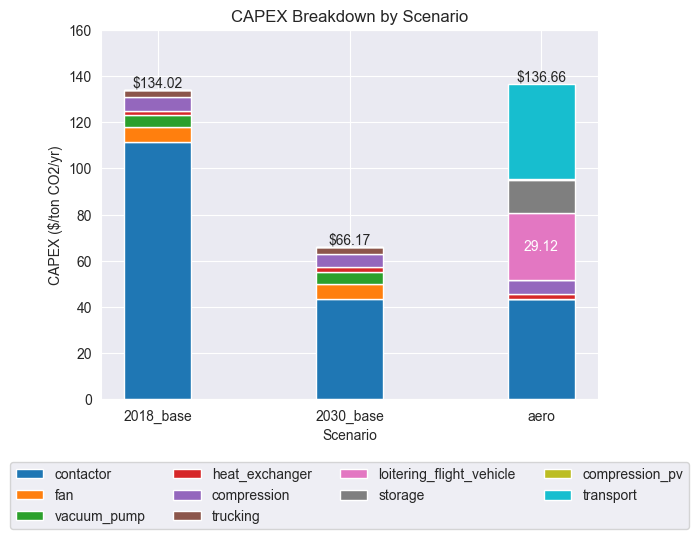

In [319]:
def plot_cost_breakdown(cost_type, scenario_labels, scenarios, categories, costs_dict):
    summed_costs = {
        year: {
            category: costs_dict[cost_type][year].get(category, 0) 
            for category in categories
        } 
        for year in scenarios
    }

    fig, ax = plt.subplots()
    bottoms = [0, 0, 0]

    for i, category in enumerate(categories):
        values = [summed_costs[year][category] for year in scenarios]
        # Determine the bottom positions for the stacked bars
        if i == 0:
            bottoms = [0] * len(values)
        else:
            previous_category = categories[i - 1]
            bottoms = [bottoms[j] + summed_costs[year][previous_category] for j, year in enumerate(scenarios)]

        bars = ax.bar(scenario_labels, values, bar_width, bottom=bottoms, label=category)
        
        if category == 'loitering_flight_vehicle':
            for bar, value in zip(bars, values):
                height = bar.get_height()
                if height > 0:  # Only label bars with a non-zero height
                    label_position_y = bar.get_y() + height / 2
                    ax.text(bar.get_x() + bar.get_width() / 2, label_position_y, f'{value:.2f}', 
                    ha='center', va='center', color='white')

    # After plotting all components, add the total data labels
    for i, scenario in enumerate(scenarios):
        total_cost = sum([summed_costs[scenario][category] for category in categories])
        ax.text(i, total_cost, f"${total_cost:.2f}", ha='center', va='bottom')

    ax.set_xlabel('Scenario')
    ax.set_ylabel(f'{cost_type.upper()} ($/ton CO2/yr)')
    ax.set_title(f'{cost_type.upper()} Breakdown by Scenario')
    ax.set_ylim(0, 160)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fancybox=True)

    plt.show()
    
capex_categories = ['contactor', 'fan', 'vacuum_pump', 'heat_exchanger', 'compression', 'trucking',
                    'loitering_flight_vehicle', 'storage', 'compression_pv', 'transport']

bar_width = 0.35
scenario_names = ['2018_base', '2030_base', 'aero']
scenario_values = ['2018', '2030', 'aero']

plot_cost_breakdown('capex', scenario_names, scenario_values, capex_categories, costs)


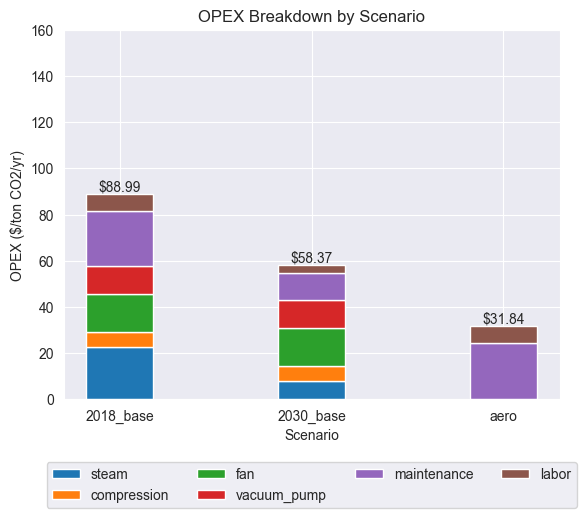

In [320]:
opex_categories = ['steam', 'compression', 'fan', 'vacuum_pump', 'maintenance', 'labor']

plot_cost_breakdown('opex', scenario_names, scenario_values, opex_categories, costs)

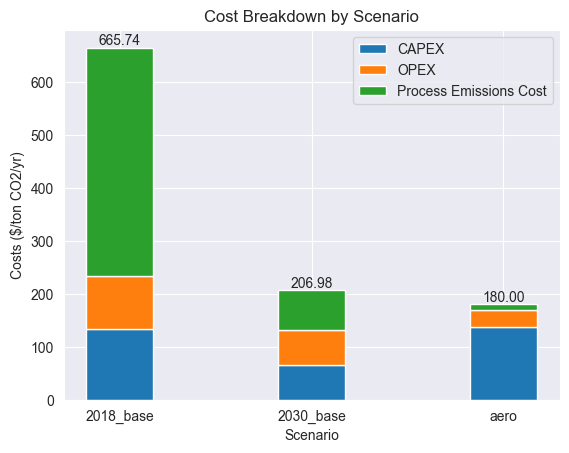

In [321]:
capex_2018 = sum(costs['capex']['2018'].values())
capex_2030 = sum(costs['capex']['2030'].values())
capex_aero = sum(costs['capex']['aero'].values())

opex_2018 = sum(costs['opex']['2018'].values())
opex_2030 = sum(costs['opex']['2030'].values())
opex_aero = sum(costs['opex']['aero'].values())

# Process emissions cost for each scenario
process_emissions_2018 = base_net_cost_2018 - total_base_cost_2018
process_emissions_2030 = base_net_cost_2030 - total_base_cost_2030
process_emissions_aero = costs["net"]["aero"] - aero_gross_cost_target

capex_values = [capex_2018, capex_2030, capex_aero]
opex_values = [opex_2018, opex_2030, opex_aero]
emissions_values = [process_emissions_2018, process_emissions_2030, process_emissions_aero]

net_fig, net_ax = plt.subplots()

net_ax.bar(scenario_names, capex_values, bar_width, label='CAPEX')
net_ax.bar(scenario_names, opex_values, bar_width, bottom=capex_values, label='OPEX')
emissions_bottom = [capex + opex for capex, opex in zip(capex_values, opex_values)]
net_bars = net_ax.bar(scenario_names, emissions_values, bar_width,
                      bottom=emissions_bottom, label='Process Emissions Cost')

# Add total data labels for each scenario
for s in range(len(scenario_names)):
    total = capex_values[s] + opex_values[s] + emissions_values[s]
    net_ax.text(s, total, f'{total:.2f}', ha='center', va='bottom')

# Adding labels and title
net_ax.set_xlabel('Scenario')
net_ax.set_ylabel('Costs ($/ton CO2/yr)')
net_ax.set_title('Cost Breakdown by Scenario')
net_ax.legend()

plt.show()